# Todo
- [x] take care of loading utils in right fodler (chatgpt)
- [ ] write in readme of RetinoMaps how you generate the files of mask and put the code in github
- [x] get code for loading 91k
- [x] load single subject 91k resample GLM inter-task output
- [x] load single concatenated 91k resting state (xcpd output)
- [x] load 91k atlas to mask concatenated 91k resting state per macro-region seed (use leaveout -to avoid seed autocorrelation)
- [x] target: mask resting state with leaveout macro-region seed
- [x] seed: create 12 seed regions masked resting state timeseries
- [x] correlate and get slope/r/stder
- [x] correct for multiple test for significance
- [x] zfisher value and stats
- [x] median avg significant seed/target vertices to end with 12 maps for 12 seeds of only significant correlations
- [x] make winner take all plot
- [x] save the gifti
- [x] plot 12 flatmaps for 12 seeds
- [x] make it python
- [x] make it a sbathc code

# Reference code
- load surface files utils
  - https://github.com/mszinte/pRF_analysis/blob/main/analysis_code/utils/surface_utils.py
    - loading: `load_surface`
    - saving: `make_surface_image`
- stats line codes :
  - usage: https://github.com/mszinte/pRF_analysis/blob/main/analysis_code/postproc/prf/postfit/compute_css_stats.py
  - utils: https://github.com/mszinte/pRF_analysis/blob/main/analysis_code/utils/maths_utils.py
  - correlation: `linear_regression_surf`
- drawing codes|
  - move back to 170k
  - or create 91k pycortex subject and utils
  - or use workbench

In [1]:
# Define main folders
main_data = '/home/mszinte/disks/meso_S/data'
main_codes = '/home/mszinte/disks/meso_H/projects'

In [2]:
# Load individual subject 91k resample GLM inter-task output
import json
import numpy as np
import os, sys
import nibabel as nb

sys.path.append(os.path.abspath(f'{main_codes}/pRF_analysis/analysis_code/utils/'))
from cifti_utils import from_91k_to_32k
from surface_utils import load_surface, make_surface_image
from maths_utils import linear_regression_surf

In [3]:
# Define settings
settings_filepath = f'{main_codes}/pRF_analysis/RetinoMaps/settings.json'
with open(settings_filepath, 'r') as file:
    settings = json.load(file)

subjects = settings['subjects']
subject = subjects[1]
task_names = settings['task_names']
task_name = task_names[0]
rois = settings['rois']
fdr_alpha = settings['fdr_alpha']

# Define finename
project = settings['project_name']
seed_folder = 'derivatives/pp_data'
atlas_folder = f'{main_codes}/pRF_analysis/analysis_code/atlas'

In [4]:
# Load resting-state dense timeseries
timeseries_fn = f'{main_data}/{project}/{seed_folder}/{subject}/91k/{task_name}/timeseries/{subject}_ses-01_task-{task_name}_space-fsLR_den-91k_desc-denoised_bold.dtseries.nii'
timeseries_img, timeseries_data_raw = load_surface(timeseries_fn)
res = from_91k_to_32k(timeseries_img, timeseries_data_raw, return_concat_hemis=True, return_32k_mask=False)
timeseries_data = res['data_concat']
print(f'Timeseries data shape: {timeseries_data.shape}')


Timeseries data shape: (996, 64984)


In [15]:
vertex_num_91k = timeseries_data.shape[1]
vexter_num_91k_lh, vexter_num_91k_rh = int(vertex_num_91k/2),int(vertex_num_91k/2)

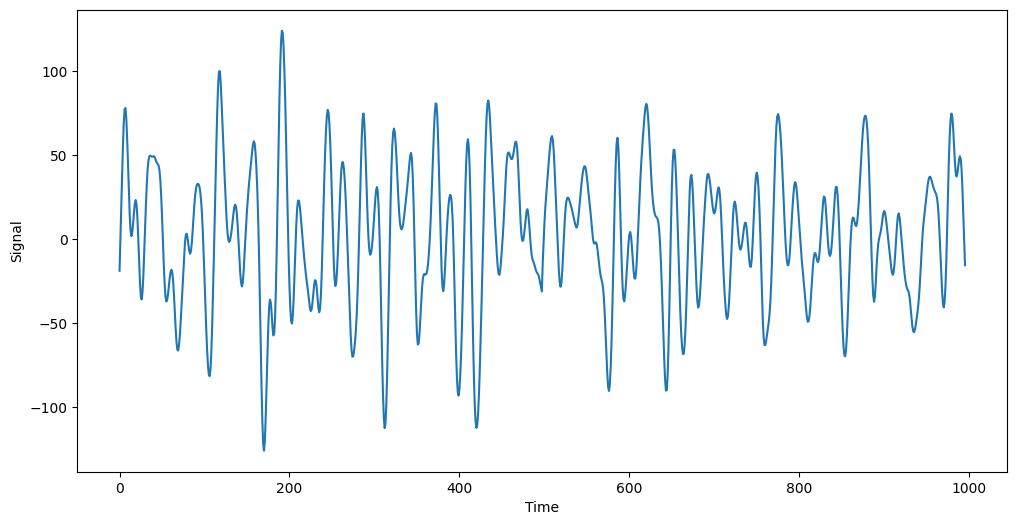

In [5]:
import matplotlib.pyplot as plt
data = timeseries_data

# Define the vertex indices you want to plot
vertex_indices = [0]
time = np.arange(data.shape[0])  # This creates an array from 0 to 995


plt.figure(figsize=(12, 6))
for index in vertex_indices:
    plt.plot(time, data[:, index], label=f'Vertex {index}')

plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()


In [6]:
# Load seed mask file as array (12,64984) from V1 to mPCS
for roi_num, roi in enumerate(rois):
    seed_mask_lh_fn = f'{main_data}/{project}/{seed_folder}/{subject}/91k/{task_name}/seed/{subject}_91k_intertask_Sac_Pur_vision-pursuit-saccade_lh_{roi}.shape.gii'
    seed_mask_lh_img, seed_mask_lh_data = load_surface(seed_mask_lh_fn)
    seed_mask_rh_fn = f'{main_data}/{project}/{seed_folder}/{subject}/91k/{task_name}/seed/{subject}_91k_intertask_Sac_Pur_vision-pursuit-saccade_rh_{roi}.shape.gii'
    seed_mask_rh_img, seed_mask_rh_data = load_surface(seed_mask_rh_fn)

    roi_seed_mask_data = np.hstack((seed_mask_lh_data, seed_mask_rh_data))

    if roi_num == 0:
        seed_mask_data = roi_seed_mask_data
    else:
        seed_mask_data = np.vstack((seed_mask_data, roi_seed_mask_data))

print(f'Seed mask data shape: {seed_mask_data.shape}')

Seed mask data shape: (12, 64984)


In [7]:
# Load leaveout macro-region target masks as array (12,64984) from V1 to mPCS
for roi_num, roi in enumerate(rois):
    leaveout_target_mask_lh_fn = f'{atlas_folder}/macro_regions/leaveout/atlas-Glasser_space-fsLR_den-32k_filtered_ROIs_discarded_leaveout_bin_lh_{roi}.shape.gii'
    leaveout_target_mask_lh_img, leaveout_target_mask_lh_data = load_surface(leaveout_target_mask_lh_fn)
    leaveout_target_mask_rh_fn = f'{atlas_folder}/macro_regions/leaveout/atlas-Glasser_space-fsLR_den-32k_filtered_ROIs_discarded_leaveout_bin_rh_{roi}.shape.gii'
    leaveout_target_mask_rh_img, leaveout_target_mask_rh_data = load_surface(leaveout_target_mask_rh_fn)

    roi_leaveout_target_mask_data = np.hstack((leaveout_target_mask_lh_data, leaveout_target_mask_rh_data))

    if roi_num == 0:
        leaveout_target_mask_data = roi_leaveout_target_mask_data
    else:
        leaveout_target_mask_data = np.vstack((leaveout_target_mask_data, roi_leaveout_target_mask_data))

print(f'Leave-out target mask data shape: {leaveout_target_mask_data.shape}')

Leave-out target mask data shape: (12, 64984)


In [13]:
# ROWS : slope / intercept / rvalue / fisher-z / pvalue / stderr / trs / pvalue adjusted for alpha1 / pvalue adjusted for alpha2`

from scipy import stats

rvalue_row = 2
pvalue_fdr_alpha1_row = -2
pvalue_fdr_alpha2_row = -1
pvalue_fdr_alpha1 = np.zeros((len(rois), vertex_num_91k)) * np.nan
pvalue_fdr_alpha2 = np.zeros((len(rois), vertex_num_91k)) * np.nan

# Correlation
for roi_num, roi in enumerate(rois):
    # Get the seed data as before
    seed_data = timeseries_data[:, seed_mask_data[roi_num,:].astype(bool)]
    
    # Create a copy of the original timeseries_data
    target_data = np.full(timeseries_data.shape, np.nan)  # Initialize with NaN

    # Apply the mask to the target_data
    target_data[:, leaveout_target_mask_data[roi_num, :].astype(bool)] = timeseries_data[:, leaveout_target_mask_data[roi_num,:].astype(bool)]
    
    print(f'{roi} Seed timeseries: {seed_data.shape}')
    print(f'{roi} Target timeseries: {target_data.shape}')

    # to accelerate debugging take first 10 (to delete)
    seed_data = seed_data[:,:3]

    for target_col in range(target_data.shape[1]):
        target_column_data = target_data[:, target_col]
        
        target_column_repeated = np.tile(target_column_data[:, np.newaxis], (1, seed_data.shape[1]))
        
        results = linear_regression_surf(bold_signal=target_column_repeated,
                                         model_prediction=seed_data,
                                         correction='fdr_tsbh', 
                                         alpha=fdr_alpha,
                                         use_fisher=True
                                        )
        
        # median of r values for significant correlations as a function of level of correctio (fdr_alpha1, fdr_alpha2)
        pvalue_fdr_alpha1[roi_num, target_col] = np.median(results[rvalue_row, :][results[pvalue_fdr_alpha1_row,:]<=fdr_alpha[0]])
        pvalue_fdr_alpha2[roi_num, target_col] = np.median(results[rvalue_row, :][results[pvalue_fdr_alpha2_row,:]<=fdr_alpha[0]])


V1 Seed timeseries: (996, 1255)
V1 Target timeseries: (996, 64984)
V2 Seed timeseries: (996, 892)
V2 Target timeseries: (996, 64984)
V3 Seed timeseries: (996, 1117)
V3 Target timeseries: (996, 64984)
V3AB Seed timeseries: (996, 423)
V3AB Target timeseries: (996, 64984)
LO Seed timeseries: (996, 165)
LO Target timeseries: (996, 64984)
VO Seed timeseries: (996, 972)
VO Target timeseries: (996, 64984)
hMT+ Seed timeseries: (996, 328)
hMT+ Target timeseries: (996, 64984)
iIPS Seed timeseries: (996, 728)
iIPS Target timeseries: (996, 64984)
sIPS Seed timeseries: (996, 1537)
sIPS Target timeseries: (996, 64984)
iPCS Seed timeseries: (996, 571)
iPCS Target timeseries: (996, 64984)
sPCS Seed timeseries: (996, 952)
sPCS Target timeseries: (996, 64984)
mPCS Seed timeseries: (996, 340)
mPCS Target timeseries: (996, 64984)


In [14]:
def find_winner(pvalue_fdr_alpha):
    winner_indices = []

    # Iterate over each column to find the winner index
    for col in range(pvalue_fdr_alpha.shape[1]):
        column_data = pvalue_fdr_alpha[:, col]
        
        # Check if all values are NaN
        if np.all(np.isnan(column_data)):
            winner_indices.append(-1)  # Append -1 for all-NaN columns
        else:
            winner_index = np.nanargmax(column_data)
            winner_indices.append(winner_index)

    # Convert winner_indices to a numpy array
    winner_indices = np.array(winner_indices)

    # Get the corresponding values, handling NaNs
    winner_values = np.array([pvalue_fdr_alpha[idx, col] if idx != -1 else np.nan 
                              for col, idx in enumerate(winner_indices)])

    # Change -1 in winner_indices to NaN
    winner_indices = np.where(winner_indices == -1, np.nan, winner_indices)

    # Stack the results
    data_with_winners = np.vstack((pvalue_fdr_alpha, winner_indices, winner_values))

    return data_with_winners

In [16]:
# Make the files with all 12 ROIS seeds, the winner index (13) and the winner r value (14)
pvalue_fdr_alpha1_with_winners = find_winner(pvalue_fdr_alpha1)
pvalue_fdr_alpha2_with_winners = find_winner(pvalue_fdr_alpha2)

In [17]:
# Save results
def save_data(data_array, template_img, data_fn):    
    data_array_img = make_surface_image(data=data_array, source_img=template_img)

    wta_darray = nb.gifti.GiftiDataArray(data_array.astype(np.float32))
    nb.save(nb.GiftiImage(darrays=[wta_darray]), data_fn)

# FDR-ALPHA1 : 0.05
pvalue_fdr_alpha1_with_winners_lh = pvalue_fdr_alpha1_with_winners[:,:vexter_num_91k_lh].T
pvalue_fdr_alpha1_with_winners_rh = pvalue_fdr_alpha2_with_winners[:,-vexter_num_91k_rh:].T

pvalue_fdr_alpha1_with_winners_lh_fn = f'{main_data}/{project}/{seed_folder}/{subject}/91k/{task_name}/corr/{subject}_ses-01_task-{task_name}_space-fsLR_den-91k_desc-full_corr_fisher-z_fdr_alpha1_L.shape.gii'
pvalue_fdr_alpha1_with_winners_rh_fn = f'{main_data}/{project}/{seed_folder}/{subject}/91k/{task_name}/corr/{subject}_ses-01_task-{task_name}_space-fsLR_den-91k_desc-full_corr_fisher-z_fdr_alpha1_R.shape.gii'
save_data(pvalue_fdr_alpha1_with_winners_lh, seed_mask_lh_img, pvalue_fdr_alpha1_with_winners_lh_fn)
save_data(pvalue_fdr_alpha1_with_winners_rh, seed_mask_rh_img, pvalue_fdr_alpha1_with_winners_rh_fn)

# FDR-ALPHA1 : 0.01
pvalue_fdr_alpha2_with_winners_lh = pvalue_fdr_alpha2_with_winners[:,:vexter_num_91k_lh].T
pvalue_fdr_alpha2_with_winners_rh = pvalue_fdr_alpha2_with_winners[:,-vexter_num_91k_rh:].T

pvalue_fdr_alpha2_with_winners_lh_fn = f'{main_data}/{project}/{seed_folder}/{subject}/91k/{task_name}/corr/{subject}_ses-01_task-{task_name}_space-fsLR_den-91k_desc-full_corr_fisher-z_fdr_alpha2_L.shape.gii'
pvalue_fdr_alpha2_with_winners_rh_fn = f'{main_data}/{project}/{seed_folder}/{subject}/91k/{task_name}/corr/{subject}_ses-01_task-{task_name}_space-fsLR_den-91k_desc-full_corr_fisher-z_fdr_alpha2_R.shape.gii'
save_data(pvalue_fdr_alpha2_with_winners_lh, seed_mask_lh_img, pvalue_fdr_alpha2_with_winners_lh_fn)
save_data(pvalue_fdr_alpha2_with_winners_rh, seed_mask_rh_img, pvalue_fdr_alpha2_with_winners_rh_fn)